In [1]:
import os
import numpy as np
from ml_pi_predictor import *
import torch
from pathlib import Path
from gsm_ve import GSM_VE
from scipy.stats import pearsonr
# temporary solution:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # to avoid  OpenMP Conflicts
# OpenMP (Open Multi-Processing) is a parallel computing API
# used to speed up computations by running code on multiple CPU cores simultaneously.
import matplotlib.pyplot as plt


In [2]:
# Define data directory

data_root_dir = Path(os.path.expanduser("~")) / "bmcs_training_data"
dataset = ViscoelasticDataset(data_root_dir, normalize=True)



Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.1A\Pi_data_10C_0.1A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.2A\Pi_data_10C_0.2A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.3A\Pi_data_10C_0.3A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.4A\Pi_data_10C_0.4A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.5A\Pi_data_10C_0.5A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.6A\Pi_data_10C_0.6A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.7A\Pi_data_10C_0.7A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.8A\Pi_data_10C_0.8A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_0.9A\Pi_data_10C_0.9A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_1.0A\Pi_data_10C_1.0A.npy
Loading data from: C:\Users\A_structure\bmcs_training_data\10C_1.1A\Pi_data_10C_1.1A.npy
Loading data from: C:

In [3]:
def gsm_ve_simulation(GSM_VE, E_val=30e+3, eta_val=30e+6, d_t_val=0.01, final_time=20, cycle=2, amp=1, HHLL=False):
    """
    Run a GSM_VE simulation with given material parameters, time step, final time, and strain amplitude.
    
    Parameters:
    GSM_VE : object
        Instance of the GSM_VE model.
    E_val : float, optional
        Young's modulus in MPa (default is 30e+3 MPa).
    eta_val : float, optional
        Viscosity modulus in Pa/s (default is 30e+6 Pa/s).
    d_t_val : float, optional
        Time step in seconds (default is 0.01 s).
    final_time : float, optional
        Final time in seconds (default is 20 s).
    cycle : float, optional
        Number of cycles for sinusoidal strain (default is 2).
    amp : float, optional
        Strain amplitude in percentage (default is 1%).
    """
    # Initialize GSM_VE object
    pi_gsm_ve = GSM_VE()
        # Define material parameters
    mparams = (E_val, eta_val)
        # Generate time vector
    time_t = np.linspace(0, final_time, int(final_time / d_t_val) + 1)
    if HHLL==True:
        trend_factor = np.linspace(5, 10, len(time_t))  # Gradually increases over time
        case_name = f"HHLL_{cycle}C_{amp}A_{final_time}S"
    else:
        trend_factor =1
        case_name = f"{cycle}C_{amp}A_{final_time}S"
    eps_t = (amp / 100) * np.sin(np.pi * cycle * time_t / final_time) * trend_factor
    
    pi_gsm_ve.problem_name = case_name
        # Perform integration
    gsm_ve_data = pi_gsm_ve.perform_integration(eps_t, time_t, *mparams)
    print(f"Processed case: {case_name}")
    save_path = pi_gsm_ve.data_dir / f'{case_name}.png'
    # Create figure and axes
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
    # Plot results
    pi_gsm_ve.plot_results(ax1, ax2, ax3, gsm_ve_data, case_name, 'blue')
    # Adjust layout
    fig.tight_layout()
    # Save the figure
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"data saved at: {pi_gsm_ve.data_dir}")
    print(f"Figure saved at: {save_path}")
    plt.close(fig)
    
    return gsm_ve_data, save_path


In [4]:
# Creation of a data sample within the space of loadining's parameters space, but not on the grid + Doubling of the loading time 
gsm_ve_simulation(GSM_VE, E_val=30e+3, eta_val=30e+6, d_t_val=0.01, final_time=40, cycle=2.5, amp=1.45)
gsm_ve_simulation(GSM_VE, E_val=30e+3, eta_val=30e+6, d_t_val=0.01, final_time=20, cycle=4, amp=1, HHLL=True)

Processed case: 2.5C_1.45A_40S
data saved at: C:\Users\A_structure\bmcs_training_data\2.5C_1.45A_40S
Figure saved at: C:\Users\A_structure\bmcs_training_data\2.5C_1.45A_40S\2.5C_1.45A_40S.png
Processed case: HHLL_4C_1A_20S
data saved at: C:\Users\A_structure\bmcs_training_data\HHLL_4C_1A_20S
Figure saved at: C:\Users\A_structure\bmcs_training_data\HHLL_4C_1A_20S\HHLL_4C_1A_20S.png


(<gsm_ve.GSM_VE.DataContainer at 0x2708d85e350>,
 WindowsPath('C:/Users/A_structure/bmcs_training_data/HHLL_4C_1A_20S/HHLL_4C_1A_20S.png'))

In [5]:
# loading sample data
# within the training space on the grid of loading parameters
sample_data_1 = np.load(data_root_dir / '2C_1.0A' / 'Pi_data_2C_1.0A.npy')  

# within the training space but between the grid of loading parameters
sample_data_2 = np.load(data_root_dir / '2.5C_1.45A_40S' / 'Pi_data_2.5C_1.45A_40S.npy') 

# within the training space but between the grid of loading parameters
sample_data_3 = np.load(data_root_dir / 'HHLL_4C_1A_20S' / 'Pi_data_HHLL_4C_1A_20S.npy') 

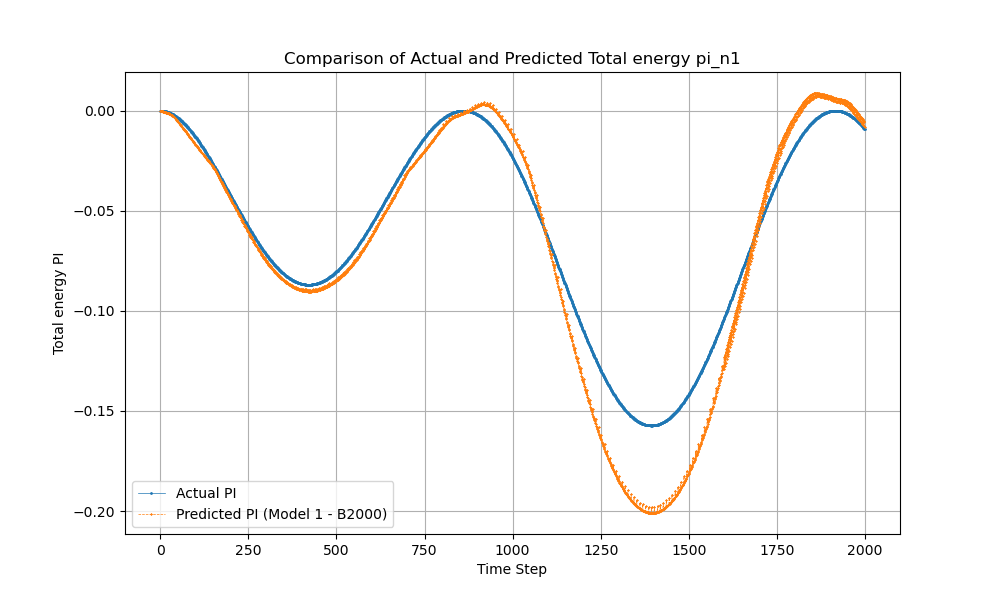

In [7]:

sample_data = sample_data_1

# Extract input and target values
eps_t = sample_data[:, 0]  
dd_eps_t = sample_data[:, 1]  
eps_v_t = sample_data[:, 2]  
d_t = sample_data[:, 3]  

# Target: next step viscoelastic strain
pi_n1 = sample_data[:, 4]

# Prepare input tensor
input_tensor = np.column_stack((eps_t, dd_eps_t, eps_v_t, d_t))

# Normalize inputs
mean = dataset.mean
std = dataset.std
input_normalized = (input_tensor - mean) / std  # Avoid division by zero
input_tensor = torch.tensor(input_normalized, dtype=torch.float32)


%matplotlib widget
# Load model class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load first model
model_1 = VE_TimeIntegrationPredictor().to(device)
model_1.load_state_dict(torch.load("ve_pi_p_e100_b2000.pth", map_location=device))
model_1.eval()

# Load second model
model_2 = VE_TimeIntegrationPredictor().to(device)
model_2.load_state_dict(torch.load("ve_pi_p_e100_b32.pth", map_location=device))
model_2.eval()

# Move input to device
input_tensor = input_tensor.to(device)

# Make predictions using both models
with torch.no_grad():
    predictions_1 = model_1(input_tensor).cpu().numpy().flatten()
    predictions_2 = model_2(input_tensor).cpu().numpy().flatten()

# Plot actual vs. predicted viscoelastic strain
plt.figure(figsize=(10, 6))
plt.plot(pi_n1, label='Actual PI', linestyle='-', marker='o', markersize=1, linewidth=0.5)
plt.plot(predictions_1-predictions_1[0], label='Predicted PI (Model 1 - B2000)', linestyle='--', marker='x', markersize=1, linewidth=0.5)
# plt.plot(predictions_2-predictions_2[0], label='Predicted PI (Model 1 - B32)', linestyle='--', marker='x', markersize=1, linewidth=0.5)


plt.xlabel("Time Step")
plt.ylabel("Total energy PI")
plt.legend()
plt.title("Comparison of Actual and Predicted Total energy pi_n1")
plt.grid()
plt.show()


MSE: 0.002961
RMSE: 0.054417
MAE: 0.051847
R^2: -0.207686
Pearson Correlation: 0.992441


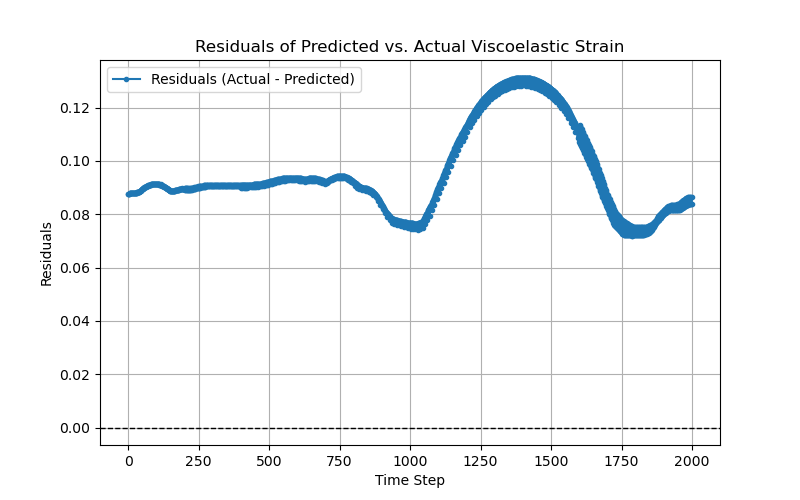

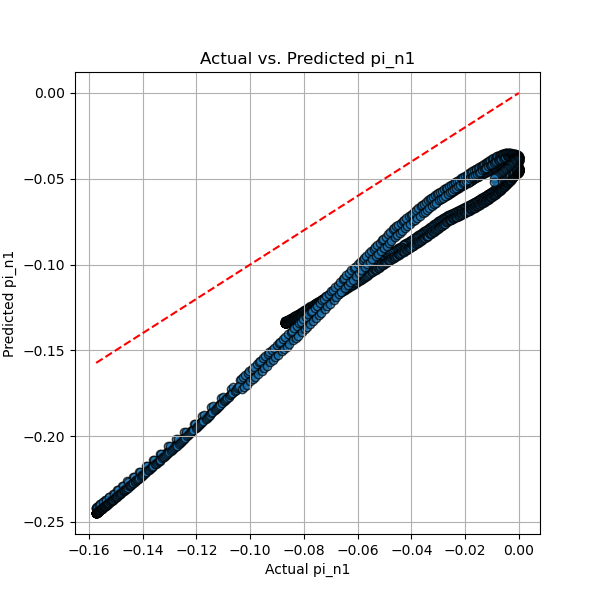

In [8]:


# Compute Mean Squared Error (MSE)
mse = np.mean((pi_n1 - predictions_1) ** 2)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(pi_n1 - predictions_1))

# Compute R-squared (R²)
ss_total = np.sum((pi_n1 - np.mean(pi_n1)) ** 2)
ss_residual = np.sum((pi_n1 - predictions_1) ** 2)
r2 = 1 - (ss_residual / ss_total)

# Compute Pearson Correlation Coefficient (r)
pearson_corr, _ = pearsonr(pi_n1, predictions_1)

# Print the metrics
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'R^2: {r2:.6f}')
print(f'Pearson Correlation: {pearson_corr:.6f}')

# Residual Plot
plt.figure(figsize=(8, 5))
residuals = pi_n1 - predictions_1 -predictions_1[0]
plt.plot(residuals, label='Residuals (Actual - Predicted)', linestyle='-', marker='o', markersize=3)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero error line
plt.xlabel("Time Step")
plt.ylabel("Residuals")
plt.legend()
plt.title("Residuals of Predicted vs. Actual Viscoelastic Strain")
plt.grid()
plt.show()

# Scatter Plot for Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(pi_n1, predictions_1, alpha=0.7, edgecolors='k')
plt.plot([min(pi_n1), max(pi_n1)], [min(pi_n1), max(pi_n1)], 'r--')  # Perfect fit line
plt.xlabel("Actual pi_n1")
plt.ylabel("Predicted pi_n1")
plt.title("Actual vs. Predicted pi_n1")
plt.grid()
plt.show()
